# Clustering & Region Segmentation — Indian Accident Dataset

**Goal:** Group regions with **similar accident profiles** (age + gender mix) without using total count, so we can identify region types for targeted policy (e.g. same cluster → similar interventions).

**Approach:** Normalize each region to **proportions** by age group (and gender); apply **K-means** and **hierarchical** clustering; name clusters (e.g. youth-heavy, senior-heavy, balanced); visualize profiles per cluster.

In [10]:
import subprocess
import sys

def ensure_package(pip_name, import_name=None):
    if import_name is None:
        import_name = pip_name
    try:
        __import__(import_name)
    except ImportError:
        print(f"Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

REQUIRED = [
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("scikit-learn", "sklearn"),
    ("scipy", "scipy"),
]
for pkg, imp in REQUIRED:
    ensure_package(pkg, imp)
print("All required libraries are available.")

All required libraries are available.


## 1. Load data and build proportion features

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Dataset/Indian-Accident-Dataset.csv")
age_groups = ['0-14', '14-18', '18-30', '30-45', '45-60', '60+']
count_cols = [c for c in df.columns if c not in ['Type', 'Region']]

# Total accidents per region
df['Total_Accidents'] = df[count_cols].sum(axis=1)

# Age-group totals (male + female) per region
for ag in age_groups:
    df[f'Age_{ag}'] = df[f'Male({ag})'] + df[f'Female({ag})']

age_cols = [f'Age_{ag}' for ag in age_groups]

# Proportions by age (each row sums to 1)
df[age_cols] = df[age_cols].div(df[age_cols].sum(axis=1), axis=0)

# Male share overall (0–1) as extra feature for "gender mix"
male_cols = [c for c in count_cols if c.startswith('Male')]
df['Male_Share'] = df[male_cols].sum(axis=1) / df[count_cols].sum(axis=1)

feature_cols = age_cols + ['Male_Share']
X = df[feature_cols].copy()
X.index = df['Region']
print("Features (proportions):")
print(X.head(8).round(3))

Features (proportions):
                   Age_0-14  Age_14-18  Age_18-30  Age_30-45  Age_45-60  \
Region                                                                    
Andhra Pradesh        0.028      0.043      0.231      0.331      0.248   
Arunachal Pradesh     0.041      0.031      0.427      0.386      0.097   
Assam                 0.032      0.076      0.328      0.359      0.162   
Bihar                 0.101      0.153      0.314      0.234      0.139   
Chhattisgarh          0.069      0.057      0.282      0.286      0.204   
Goa                   0.013      0.013      0.282      0.302      0.218   
Gujarat               0.027      0.043      0.249      0.338      0.244   
Haryana               0.026      0.038      0.315      0.347      0.202   

                   Age_60+  Male_Share  
Region                                  
Andhra Pradesh       0.118       0.842  
Arunachal Pradesh    0.018       0.870  
Assam                0.042       0.819  
Bihar               

## 2. Scale and choose number of clusters (K-means)

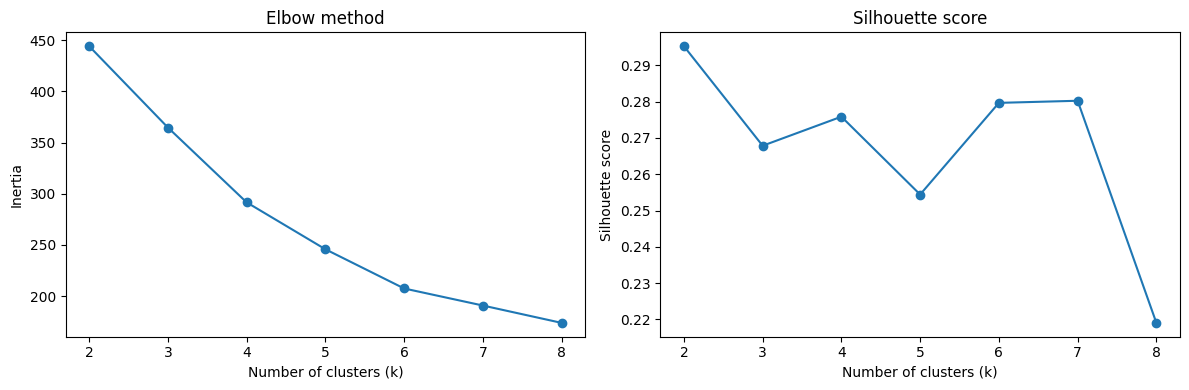

Suggested k (best silhouette): 2


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow and silhouette for k=2..8
from sklearn.metrics import silhouette_score

inertias, silhouettes = [], []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(K_range, inertias, 'o-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow method')
ax2.plot(K_range, silhouettes, 'o-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette score')
ax2.set_title('Silhouette score')
plt.tight_layout()
plt.show()

k_best = int(np.argmax(silhouettes) + 2)  # k with best silhouette in 2..8
print(f"Suggested k (best silhouette): {k_best}")

## 3. Fit K-means and assign cluster labels

In [13]:
n_clusters = k_best  # or set manually, e.g. 4
km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = km.fit_predict(X_scaled)

print("Regions per cluster:")
print(df.groupby('Cluster').agg(Region_count=('Region', 'count'), Regions=('Region', list)).to_string())

Regions per cluster:
         Region_count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Regions
Cluster                                                                                                                                                                                                                                                                                                                           

## 4. Name clusters by dominant age profile

Label each cluster as youth-heavy (0–14, 14–18), working-age (18–30, 30–45), senior-heavy (45–60, 60+), or balanced.

In [14]:
cluster_profiles = df.groupby('Cluster')[age_cols].mean()

def name_cluster(row):
    ag = age_groups[np.argmax(row.values)]
    if ag in ['0-14', '14-18']:
        return 'Youth-heavy'
    if ag in ['18-30', '30-45']:
        return 'Working-age dominant'
    if ag in ['45-60', '60+']:
        return 'Senior-heavy'
    return 'Balanced'

cluster_names = cluster_profiles.apply(name_cluster, axis=1)
for c in cluster_profiles.index:
    dominant = age_groups[np.argmax(cluster_profiles.loc[c].values)]
    cluster_names[c] = f"{cluster_names[c]} (peak: {dominant})"

df['Cluster_Name'] = df['Cluster'].map(cluster_names)
print(cluster_names.to_string())

Cluster
0    Working-age dominant (peak: 30-45)
1            Senior-heavy (peak: 45-60)


## 5. Cluster profile plots (mean proportions by age)

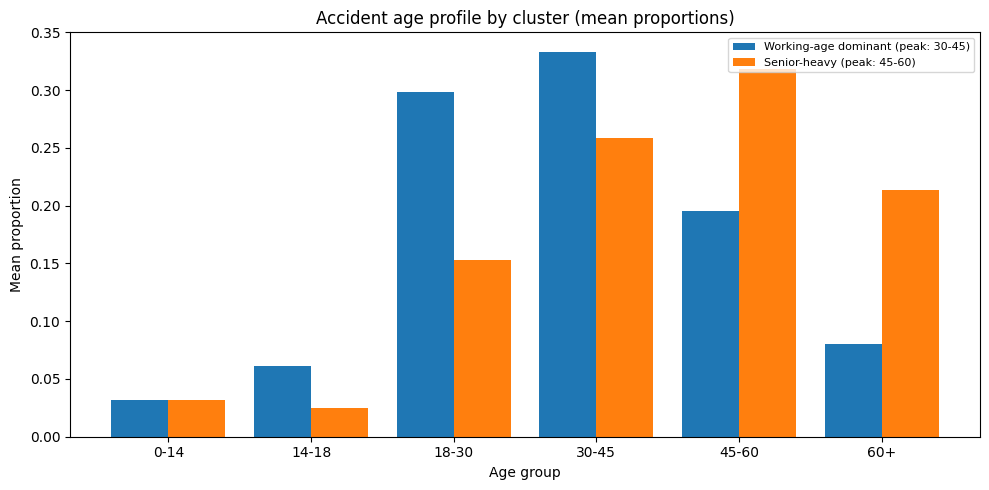

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(age_groups))
width = 0.8 / n_clusters
for i, cl in enumerate(sorted(df['Cluster'].unique())):
    offset = (i - n_clusters/2 + 0.5) * width
    means = cluster_profiles.loc[cl].values
    ax.bar(x + offset, means, width, label=cluster_names[cl])
ax.set_xticks(x)
ax.set_xticklabels(age_groups)
ax.set_ylabel('Mean proportion')
ax.set_xlabel('Age group')
ax.set_title('Accident age profile by cluster (mean proportions)')
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

## 6. Heatmap: clusters × age proportions

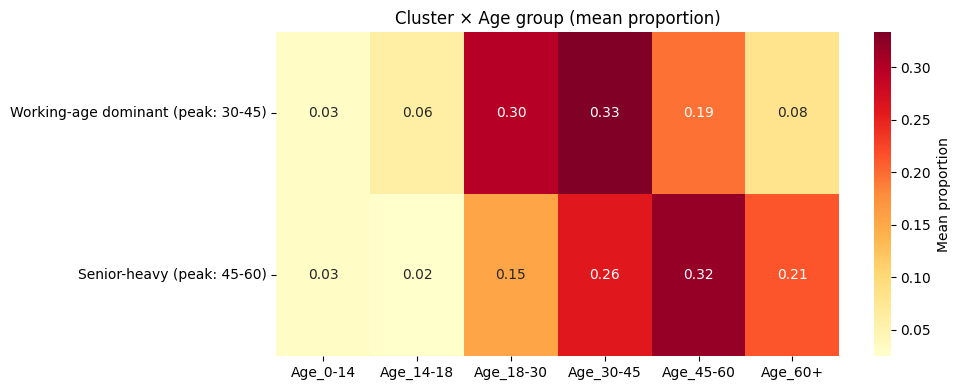

In [16]:
heat_df = cluster_profiles.copy()
heat_df.index = [cluster_names[i] for i in heat_df.index]
fig, ax = plt.subplots(figsize=(10, max(4, n_clusters * 0.8)))
sns.heatmap(heat_df, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Mean proportion'})
ax.set_title('Cluster × Age group (mean proportion)')
plt.tight_layout()
plt.show()

## 7. Regions per cluster (table)

In [17]:
for cl in sorted(df['Cluster'].unique()):
    name = cluster_names[cl]
    regions = df[df['Cluster'] == cl]['Region'].tolist()
    print(f"\n--- Cluster {cl}: {name} ({len(regions)} regions) ---")
    print(regions)


--- Cluster 0: Working-age dominant (peak: 30-45) (57 regions) ---
['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Madhya Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Chandigarh', 'Dadra and Nicobar Haveli and Daman and Diu', 'Delhi', 'Jammu and Kashmir', 'Ladakh', 'Agra', 'Allahabad', 'Bhopal', 'Chandigarh (City)', 'Delhi (City)', 'Dhanbad', 'Faridabad', 'Ghaziabad', 'Gwalior', 'Hyderabad', 'Indore', 'Jabalpur', 'Jaipur', 'Jamshedpur', 'Jodhpur', 'Kanpur', 'Kota', 'Lucknow', 'Ludhiana', 'Meerut', 'Patna', 'Raipur', 'Rajkot', 'Surat', 'Varanasi', 'Vasai Virar', 'Vishakhapatnam']

--- Cluster 1: Senior-heavy (peak: 45-60) (32 regions) ---
['Kerala', 'Maharashtra', 'Tamil Nadu', 'Andaman and Nicobar Islands', 'Lakshadweep', 'Puducherry', 'Ahmedabad', 'Amritsar',

## 8. Optional: 2D visualization (PCA)

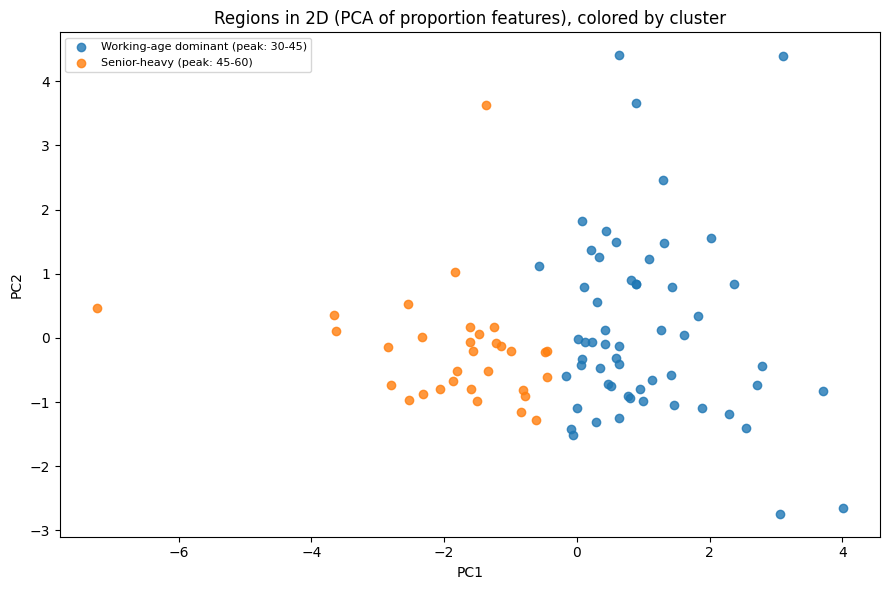

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(9, 6))
for cl in sorted(df['Cluster'].unique()):
    mask = df['Cluster'] == cl
    ax.scatter(X2[mask, 0], X2[mask, 1], label=cluster_names[cl], alpha=0.8)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Regions in 2D (PCA of proportion features), colored by cluster')
ax.legend(loc='best', fontsize=8)
plt.tight_layout()
plt.show()

## 9. Optional: Hierarchical clustering dendrogram

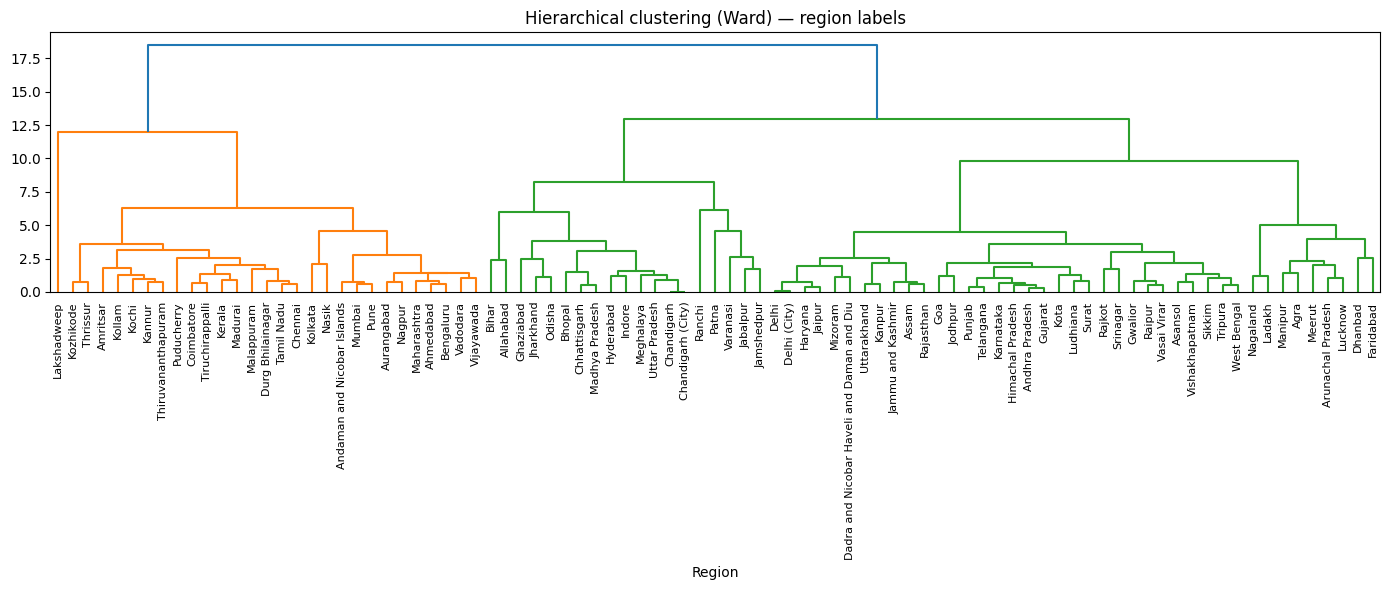

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_scaled, method='ward')
fig, ax = plt.subplots(figsize=(14, 6))
dendrogram(Z, labels=df['Region'].values, leaf_rotation=90, leaf_font_size=8, ax=ax)
ax.set_title('Hierarchical clustering (Ward) — region labels')
ax.set_xlabel('Region')
plt.tight_layout()
plt.show()